## 1. Постановка задачи



<center> <img src=https://raw.githubusercontent.com/hoittoken/Python/master/Py/Projects/project_5/logo%20v1.1.png align="left"> </center>

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

## Напишем всякие полезные функции:

In [3]:
def add_datetime_features(data, feature='pickup_datetime'):
    
    data['pickup_date'] = data[feature].dt.date
    data['pickup_hour'] = data[feature].dt.hour
    data['pickup_day_of_week'] = data[feature].dt.dayofweek
    
    return data

In [4]:
def add_holiday_features(df, holiday_data):
    holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date
    df = df.merge(holiday_data, how='left', left_on='pickup_date', right_on='date')
    df['pickup_holiday'] = df['holiday'].fillna(0)
    df['pickup_holiday'] = df['pickup_holiday'].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(['day', 'date', 'holiday'], axis=1)
    return df   

In [5]:
def add_osrm_features(data, data_2, on='id', how='left', columns = ['id','total_distance', 'total_travel_time', 'number_of_steps']):
    merged_data = data.merge(
        data_2[columns],
        on=on,
        how=how
    )
    return merged_data

In [6]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

def add_geographical_features(
    data, 
    lat1='pickup_latitude', 
    lng1='pickup_longitude',
    lat2='dropoff_latitude', 
    lng2='dropoff_longitude', 
    name_1='haversine_distance', name_2='direction'):
    
    data[name_1] = get_haversine_distance(data[lat1], data[lng1], data[lat2], data[lng2])
    
    data[name_2] = get_angle_direction(data[lat1], data[lng1], data[lat2], data[lng2])
    
    return data

In [7]:
def add_cluster_features(taxi_data):
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    pred = kmeans.predict(coords)
    pred = kmeans.labels_
    taxi_data['geo_cluster'] = pred
    return taxi_data


In [8]:
def add_weather_features(taxi_data, weather_data):
    
    weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
    taxi_data['date_&_hour'] = [(x, y) for x, y in zip(taxi_data['pickup_datetime'].dt.date, taxi_data['pickup_datetime'].dt.hour)]
    weather_data['date_&_hour'] = [(x, y) for x, y in zip(weather_data['time'].dt.date, weather_data['time'].dt.hour)]
    
    weather_data = weather_data.loc[:, ['date_&_hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']] 
    
    df = taxi_data.merge(
        weather_data,
        on = 'date_&_hour',
        how = 'left'
    )
    df.drop('date_&_hour', axis=1, inplace=True)
    return df

In [9]:
def fill_null_weather_data(taxi_data):
    cols_with_null = taxi_data.isnull().mean()
    cols_with_null = cols_with_null[cols_with_null > 0]
    for col in cols_with_null.index:
        if col == 'events':
            taxi_data[col] = taxi_data[col].fillna('None')
        else:
            taxi_data[col] = taxi_data[col].fillna(taxi_data.groupby('pickup_date')[col].transform('median'))
    return taxi_data

In [17]:
osrm_data_test = pd.read_csv("C:\Личные документы\Учёба SF DS\data\Project5_osrm_data_test.zip")
test_data = pd.read_csv("C:\Личные документы\Учёба SF DS\data\Project5_test_data.zip")
holiday_data = pd.read_csv('holiday_data.csv', sep=";")
weather_data = pd.read_csv('weather_data.zip')
test_id = test_data['id']

In [10]:
osrm_data_train = pd.read_csv("C:\Личные документы\Учёба SF DS\data\osrm_data_train.zip")
train_data = pd.read_csv("C:\Личные документы\Учёба SF DS\data\Project5_train_data.zip")
holiday_data = pd.read_csv('holiday_data.csv', sep=";")
weather_data = pd.read_csv('weather_data.zip')


In [11]:
from sklearn.preprocessing import OneHotEncoder

scaler = preprocessing.MinMaxScaler()
one_hot_encoder = OneHotEncoder()

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

best_features = ['pickup_hour', 'dropoff_latitude', 'pickup_longitude', 
 'haversine_distance', 'pickup_latitude', 'dropoff_longitude',
 'total_distance', 'total_travel_time', 'temperature', 'number_of_steps',
 'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
 'vendor_id', 'passenger_count', 'pickup_day_of_week_3', 'geo_cluster_9',
 'pickup_day_of_week_1', 'pickup_day_of_week_2', 'geo_cluster_1',
 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7', 'store_and_fwd_flag'
 ]

In [12]:
# Train set

train_data['pickup_datetime']=pd.to_datetime(train_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train_data = add_datetime_features(train_data)
train_data = add_holiday_features(train_data, holiday_data)
train_data = add_osrm_features(train_data, osrm_data_train)
train_data = add_geographical_features(train_data)
train_data = add_cluster_features(train_data)
train_data = add_weather_features(train_data, weather_data)
train_data = fill_null_weather_data(train_data)

train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
train_data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
train_data_onehot = pd.DataFrame(train_data_onehot, columns=column_names)

train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), train_data_onehot], 
    axis=1
)
train_data = train_data.dropna(axis=1)
train_data['trip_duration_log'] = np.log(train_data['trip_duration']+1)

In [14]:
X = train_data[best_features]
scaler.fit(X)
X_test_scaled = scaler.transform(X)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']


In [15]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

In [19]:
import xgboost as xgb
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test, feature_names=best_features)

In [20]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42171	valid-rmse:5.42130
[10]	train-rmse:1.93626	valid-rmse:1.93698
[20]	train-rmse:0.78730	valid-rmse:0.78843
[30]	train-rmse:0.48194	valid-rmse:0.48319
[40]	train-rmse:0.42488	valid-rmse:0.42616
[50]	train-rmse:0.41277	valid-rmse:0.41424
[60]	train-rmse:0.40816	valid-rmse:0.41017
[70]	train-rmse:0.40449	valid-rmse:0.40684
[80]	train-rmse:0.40270	valid-rmse:0.40546
[90]	train-rmse:0.40077	valid-rmse:0.40378
[100]	train-rmse:0.39917	valid-rmse:0.40249
[110]	train-rmse:0.39793	valid-rmse:0.40160
[120]	train-rmse:0.39636	valid-rmse:0.40039
[130]	train-rmse:0.39500	valid-rmse:0.39932
[140]	train-rmse:0.39404	valid-rmse:0.39863
[150]	train-rmse:0.39324	valid-rmse:0.39815
[160]	train-rmse:0.39271	valid-rmse:0.39788
[170]	train-rmse:0.39190	valid-rmse:0.39747
[180]	train-rmse:0.39112	valid-rmse:0.39702
[190]	train-rmse:0.39039	valid-rmse:0.39665
[200]	train-rmse:0.38963	valid-rmse:0.39627
[210]	train-rmse:0.38891	valid-rmse:0.39585
[220]	train-rmse:0.38822	valid-rmse:0.39552

In [37]:
model.inplace_predict(X_train)

array([5.7583346, 6.9566746, 7.943936 , ..., 7.2537613, 5.787264 ,
       7.313301 ], dtype=float32)

In [39]:
y_train_pred = model.inplace_predict(X_train)
y_valid_pred = model.inplace_predict(X_valid)
y_train_pred = np.log(y_train_pred)
y_valid_pred = np.log(y_valid_pred)

In [40]:
def rmsle(y_real, y_pred):
    mse = np.sum(np.square(np.subtract(y_real, y_pred))) / len(y_real)
    return np.sqrt(mse)

In [41]:
print(f"RMSLE on train: {rmsle(y_train_log, y_train_pred)}")
print(f"RMSLE on valid: {rmsle(y_valid_log, y_valid_pred)}")

RMSLE on train: 4.659455765457128
RMSLE on valid: 4.659262554133632


In [31]:
y_train_pred = np.exp(y_train_pred) - 1
y_valid_pred = np.exp(y_valid_pred) - 1
y_train_real = np.exp(y_train_log) - 1
y_valid_real = np.exp(y_valid_log) - 1

from sklearn.metrics import median_absolute_error


MeAE = median_absolute_error(y_valid_real, y_valid_pred) / 60


print(f"MeAE on valid: {round(MeAE, 1)}")

MeAE on valid: 10.9


# to kaggle

In [18]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 24)


In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

После чего модуль можно импортировать:

In [173]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [175]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [176]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93577	valid-rmse:1.93572
[20]	train-rmse:0.78516	valid-rmse:0.78602
[30]	train-rmse:0.47918	valid-rmse:0.48121
[40]	train-rmse:0.42142	valid-rmse:0.42405
[50]	train-rmse:0.40929	valid-rmse:0.41237
[60]	train-rmse:0.40478	valid-rmse:0.40826
[70]	train-rmse:0.40168	valid-rmse:0.40561
[80]	train-rmse:0.39942	valid-rmse:0.40364
[90]	train-rmse:0.39752	valid-rmse:0.40209
[100]	train-rmse:0.39572	valid-rmse:0.40058
[110]	train-rmse:0.39410	valid-rmse:0.39932
[120]	train-rmse:0.39331	valid-rmse:0.39879
[130]	train-rmse:0.39201	valid-rmse:0.39783
[140]	train-rmse:0.39096	valid-rmse:0.39711
[150]	train-rmse:0.38999	valid-rmse:0.39655
[160]	train-rmse:0.38924	valid-rmse:0.39606
[170]	train-rmse:0.38852	valid-rmse:0.39567
[180]	train-rmse:0.38786	valid-rmse:0.39524
[190]	train-rmse:0.38716	valid-rmse:0.39492
[200]	train-rmse:0.38645	valid-rmse:0.39447
[210]	train-rmse:0.38563	valid-rmse:0.39400
[220]	train-rmse:0.38505	valid-rmse:0.39372

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [177]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39163


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

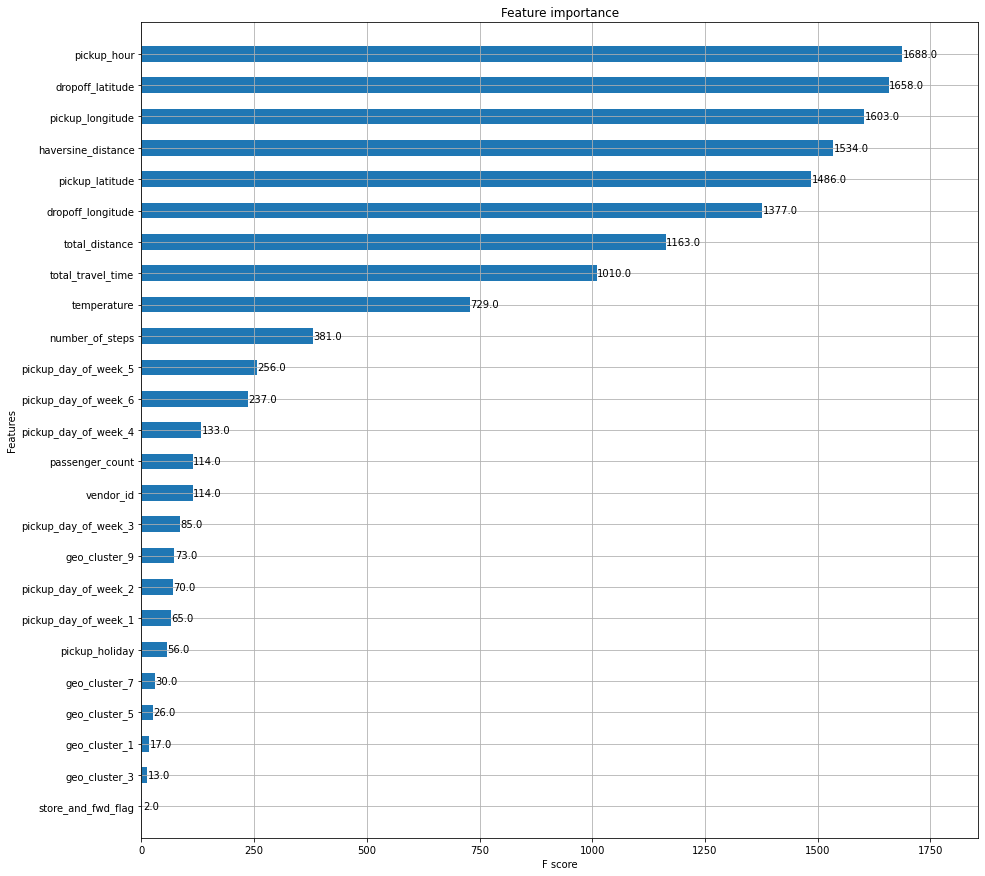

In [178]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)